<a href="https://colab.research.google.com/github/IlkerCTL/EE-608/blob/main/EE_608_Machine_Translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Machine Translation with Keras


In this notebook, I will build a deep neural network that functions as part of an end-to-end machine translation pipeline. Completed pipeline will accept English text as input and return the French translation.

- **Preprocessing** - I will convert text to sequence of integers.
- **Modeling** I will create a model which accepts a sequence of integers as input and returns a probability distribution over possible translations. 
- **Prediction** I will run the model on English text.

In [ ]:
import collections
import numpy as np
import os

from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional
from tensorflow.keras.layers import Embedding
from keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy
from keras.utils import plot_model
from keras.models import Sequential
import keras

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Verify access to the GPU


In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10109642003847019057
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14415560704
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4378881467406213812
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


## Dataset
The most common datasets used for machine translation are from [WMT](http://www.statmt.org/).  However, that will take a long time to train a neural network on.  I'll be using a dataset for this project that contains a small vocabulary. I'll be able to train my model in a reasonable time with this dataset.


In [ ]:
# create a folder in the drive named pytorch_seg
import os
try:
    os.mkdir("/content/drive/MyDrive/Machine_Translation/")
except FileExistsError:
    print('directory already exists')

#download the dataset
!wget --no-check-certificate https://raw.githubusercontent.com/IlkerCTL/EE-608/main/small_vocab_en -P "/content/drive/MyDrive/Machine_Translation"
!wget --no-check-certificate https://raw.githubusercontent.com/IlkerCTL/EE-608/main/small_vocab_fr -P "/content/drive/MyDrive/Machine_Translation"


directory already exists
--2022-12-16 00:05:58--  https://raw.githubusercontent.com/IlkerCTL/ee608/main/small_vocab_en
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9085267 (8.7M) [text/plain]
Saving to: ‘/content/drive/MyDrive/Machine_Translation/small_vocab_en.1’

small_vocab_en.1    100%[===================>]   8.66M  51.0MB/s    in 0.2s    

2022-12-16 00:05:58 (51.0 MB/s) - ‘/content/drive/MyDrive/Machine_Translation/small_vocab_en.1’ saved [9085267/9085267]

--2022-12-16 00:05:58--  https://raw.githubusercontent.com/IlkerCTL/ee608/main/small_vocab_fr
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.1

In [ ]:
# define a function to load the dataset
def load_data(path):
    """
    Load dataset
    """
    input_file = os.path.join(path)
    with open(input_file, "r") as f:
        data = f.read()

    return data.split('\n')

In [ ]:
# Load English data
english_sentences = load_data('/content/drive/MyDrive/Machine_Translation/small_vocab_en')
# Load French data
french_sentences = load_data('/content/drive/MyDrive/Machine_Translation/small_vocab_fr')

print('Dataset Loaded')

Dataset Loaded


In [ ]:
"""Each line in small_vocab_en contains an English sentence with the respective translation-
in each line of small_vocab_fr. View the first two lines from each file."""
for sample_i in range(2):
    print('small_vocab_en Line {}:  {}'.format(sample_i + 1, english_sentences[sample_i]))
    print('small_vocab_fr Line {}:  {}'.format(sample_i + 1, french_sentences[sample_i]))

small_vocab_en Line 1:  new jersey is sometimes quiet during autumn , and it is snowy in april .
small_vocab_fr Line 1:  new jersey est parfois calme pendant l' automne , et il est neigeux en avril .
small_vocab_en Line 2:  the united states is usually chilly during july , and it is usually freezing in november .
small_vocab_fr Line 2:  les états-unis est généralement froid en juillet , et il gèle habituellement en novembre .


Sentences have been preprocessed already. The puncuations have been delimited using spaces. All the text have been converted to lowercase.  This should save some time, but the text requires more preprocessing.
### Vocabulary
The complexity of the problem is determined by the complexity of the vocabulary.  A more complex vocabulary is a more complex problem.  

In [ ]:
english_words_counter = collections.Counter([word for sentence in english_sentences for word in sentence.split()])
french_words_counter = collections.Counter([word for sentence in french_sentences for word in sentence.split()])

print('{} English words.'.format(len([word for sentence in english_sentences for word in sentence.split()])))
print('{} unique English words.'.format(len(english_words_counter)))
print('10 Most common words in the English dataset:')
print('"' + '" "'.join(list(zip(*english_words_counter.most_common(10)))[0]) + '"')
print()
print('{} French words.'.format(len([word for sentence in french_sentences for word in sentence.split()])))
print('{} unique French words.'.format(len(french_words_counter)))
print('10 Most common words in the French dataset:')
print('"' + '" "'.join(list(zip(*french_words_counter.most_common(10)))[0]) + '"')

1823250 English words.
227 unique English words.
10 Most common words in the English dataset:
"is" "," "." "in" "it" "during" "the" "but" "and" "sometimes"

1961295 French words.
355 unique French words.
10 Most common words in the French dataset:
"est" "." "," "en" "il" "les" "mais" "et" "la" "parfois"


## Preprocess
For this project, I won't use text data as input to the model. Instead, I'll convert the text into sequences of integers using the following preprocess methods:
1. Tokenize the words into ids
2. Add padding to make all the sequences the same length.


### Tokenization
For a neural network to predict text data, it first has to be turned into data that, it can understand. 

Text data like "dog" is a sequence of ASCII character encodings.  Since a neural network is a series of multiplication and addition operations, the input data needs to be **number(s).**

I can turn each character into a number or each word into a number.  These are called character and word ids, respectively.  Character ids are used for character level models that generate text predictions for each character.  

A word level model uses word ids that generate text predictions for each word.  Word level models tend to learn better, since they are lower in complexity, so I'll use those.

I will turn each sentence into a sequence of words ids using Keras's `Tokenizer` function. I will use this function to tokenize `english_sentences` and `french_sentences` in the cell below.


In [ ]:
def tokenize(x):
    """
    Tokenize x
    :param x: List of sentences/strings to be tokenized
    :return: Tuple of (tokenized x data, tokenizer used to tokenize x)
    """
    x_tk = Tokenizer(char_level = False)
    x_tk.fit_on_texts(x)
    return x_tk.texts_to_sequences(x), x_tk

# Tokenize Example output
text_sentences = [
    'The quick brown fox jumps over the lazy dog .',
    'By Jove , my quick study of lexicography won a prize .',
    'This is a short sentence .']
text_tokenized, text_tokenizer = tokenize(text_sentences)
print(text_tokenizer.word_index)
print()
for sample_i, (sent, token_sent) in enumerate(zip(text_sentences, text_tokenized)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(sent))
    print('  Output: {}'.format(token_sent))

{'the': 1, 'quick': 2, 'a': 3, 'brown': 4, 'fox': 5, 'jumps': 6, 'over': 7, 'lazy': 8, 'dog': 9, 'by': 10, 'jove': 11, 'my': 12, 'study': 13, 'of': 14, 'lexicography': 15, 'won': 16, 'prize': 17, 'this': 18, 'is': 19, 'short': 20, 'sentence': 21}

Sequence 1 in x
  Input:  The quick brown fox jumps over the lazy dog .
  Output: [1, 2, 4, 5, 6, 7, 1, 8, 9]
Sequence 2 in x
  Input:  By Jove , my quick study of lexicography won a prize .
  Output: [10, 11, 12, 2, 13, 14, 15, 16, 3, 17]
Sequence 3 in x
  Input:  This is a short sentence .
  Output: [18, 19, 3, 20, 21]


### Padding 
When batching the sequence of word ids together, each sequence needs to be the same length.  Since sentences are dynamic in length, I can add padding to the end of the sequences to make them the same length.

I make sure all the English sequences have the same length and all the French sequences have the same length by adding padding to the **end** of each sequence using Keras's `pad_sequences` function.

In [ ]:
def pad(x, length=None):
    """
    Pad x
    :param x: List of sequences.
    :param length: Length to pad the sequence to.  If None, use length of longest sequence in x.
    :return: Padded numpy array of sequences
    """
    if length is None:
        length = max([len(sentence) for sentence in x])
    return pad_sequences(x, maxlen = length, padding = 'post')


# Pad Tokenized output
test_pad = pad(text_tokenized)
for sample_i, (token_sent, pad_sent) in enumerate(zip(text_tokenized, test_pad)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(np.array(token_sent)))
    print('  Output: {}'.format(pad_sent))

Sequence 1 in x
  Input:  [1 2 4 5 6 7 1 8 9]
  Output: [1 2 4 5 6 7 1 8 9 0]
Sequence 2 in x
  Input:  [10 11 12  2 13 14 15 16  3 17]
  Output: [10 11 12  2 13 14 15 16  3 17]
Sequence 3 in x
  Input:  [18 19  3 20 21]
  Output: [18 19  3 20 21  0  0  0  0  0]


### Preprocess Pipeline


In [ ]:
def preprocess(x, y):
    """
    Preprocess x and y
    :param x: Feature List of sentences
    :param y: Label List of sentences
    :return: Tuple of (Preprocessed x, Preprocessed y, x tokenizer, y tokenizer)
    """
    preprocess_x, x_tk = tokenize(x)
    preprocess_y, y_tk = tokenize(y)

    preprocess_x = pad(preprocess_x)
    preprocess_y = pad(preprocess_y)

    # Keras's sparse_categorical_crossentropy function requires the labels to be in 3 dimensions
    preprocess_y = preprocess_y.reshape(*preprocess_y.shape, 1)

    return preprocess_x, preprocess_y, x_tk, y_tk

preproc_english_sentences, preproc_french_sentences, english_tokenizer, french_tokenizer =\
    preprocess(english_sentences, french_sentences)
    
max_english_sequence_length = preproc_english_sentences.shape[1]
max_french_sequence_length = preproc_french_sentences.shape[1]
english_vocab_size = len(english_tokenizer.word_index)
french_vocab_size = len(french_tokenizer.word_index)

print('Data Preprocessed')
print("Max English sentence length:", max_english_sequence_length)
print("Max French sentence length:", max_french_sequence_length)
print("English vocabulary size:", english_vocab_size)
print("French vocabulary size:", french_vocab_size)

Data Preprocessed
Max English sentence length: 15
Max French sentence length: 21
English vocabulary size: 199
French vocabulary size: 344


## Models


### Ids Back to Text
The neural network will be translating the input to words ids, which isn't the final form I want.  I want the French translation.  The function `logits_to_text` will bridge the gab between the logits from the neural network to the French translation.  I'll be using this function to better understand the output of the neural network.

In [ ]:
def logits_to_text(logits, tokenizer):
    """
    Turn logits from a neural network into text using the tokenizer
    :param logits: Logits from a neural network
    :param tokenizer: Keras Tokenizer fit on the labels
    :return: String that represents the text of the logits
    """
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

print('`logits_to_text` function loaded.')

`logits_to_text` function loaded.


### Model implemenation


In [ ]:
from keras.metrics import SparseCategoricalAccuracy

def model_final(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a model that incorporates embedding, encoder-decoder, and bidirectional RNN on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """

    model = Sequential()
    model.add(Embedding(input_dim=english_vocab_size,output_dim=128,input_length=input_shape[1]))
    model.add(Bidirectional(GRU(256,return_sequences=False)))
    model.add(RepeatVector(output_sequence_length))
    model.add(Bidirectional(GRU(256,return_sequences=True)))
    model.add(TimeDistributed(Dense(french_vocab_size,activation='softmax')))
    learning_rate = 0.005
    
    model.compile(loss = sparse_categorical_crossentropy, 
                 optimizer = Adam(learning_rate), 
                 metrics = [SparseCategoricalAccuracy()])
    
    return model

print('Model Loaded')


Model Loaded


In [ ]:
#Define the model
tmp_X = pad(preproc_english_sentences)
model = model_final(tmp_X.shape,
                    preproc_french_sentences.shape[1],
                    len(english_tokenizer.word_index)+1,
                    len(french_tokenizer.word_index)+1)

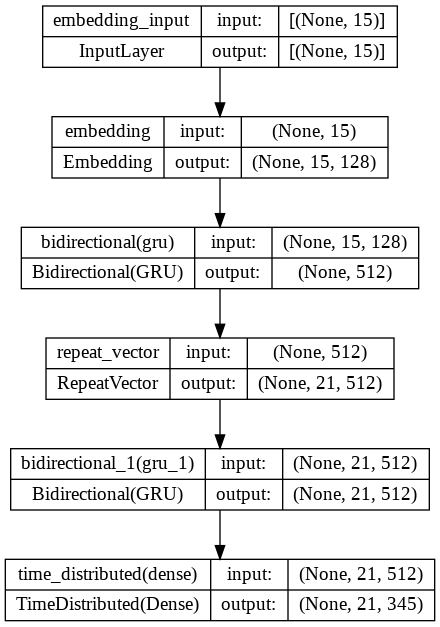

In [ ]:
# Visualize the model
keras.utils.plot_model(model, "model_with_shape_info.png", show_shapes=True)

### Train the model 

In [ ]:
hist = model.fit(tmp_X, preproc_french_sentences, batch_size = 1024, epochs = 15, validation_split = 0.2)

Epoch 1/15
108/108 [==============================] - 22s 102ms/step - loss: 2.0944 - sparse_categorical_accuracy: 0.5299 - val_loss: 1.3103 - val_sparse_categorical_accuracy: 0.6498
Epoch 2/15
108/108 [==============================] - 10s 96ms/step - loss: 1.0152 - sparse_categorical_accuracy: 0.7146 - val_loss: 0.7560 - val_sparse_categorical_accuracy: 0.7775
Epoch 3/15
108/108 [==============================] - 10s 92ms/step - loss: 0.5791 - sparse_categorical_accuracy: 0.8261 - val_loss: 0.3988 - val_sparse_categorical_accuracy: 0.8811
Epoch 4/15
108/108 [==============================] - 10s 92ms/step - loss: 0.3182 - sparse_categorical_accuracy: 0.9045 - val_loss: 0.2406 - val_sparse_categorical_accuracy: 0.9283
Epoch 5/15
108/108 [==============================] - 10s 95ms/step - loss: 0.1941 - sparse_categorical_accuracy: 0.9420 - val_loss: 0.2004 - val_sparse_categorical_accuracy: 0.9393
Epoch 6/15
108/108 [==============================] - 10s 95ms/step - loss: 0.1954 - spar

### Evaluate the model

In [ ]:
def final_predictions(x, y, x_tk, y_tk):
    """
    Gets predictions using the model
    :param x: Preprocessed English data
    :param y: Preprocessed French data
    :param x_tk: English tokenizer
    :param y_tk: French tokenizer
    """
    y_id_to_word = {value: key for key, value in y_tk.word_index.items()}
    y_id_to_word[0] = '<PAD>'

    sentence = 'he saw a old yellow truck'
    sentence = [x_tk.word_index[word] for word in sentence.split()]
    sentence = pad_sequences([sentence], maxlen=x.shape[-1], padding='post')
    sentences = np.array([sentence[0], x[0]])
    predictions = model.predict(sentences, len(sentences))

    print('Sample 1:')
    print(' '.join([y_id_to_word[np.argmax(x)] for x in predictions[0]]))
    print('Il a vu un vieux camion jaune')
    print('Sample 2:')
    print(' '.join([y_id_to_word[np.argmax(x)] for x in predictions[1]]))
    print(' '.join([y_id_to_word[np.max(x)] for x in y[0]]))


final_predictions(preproc_english_sentences, preproc_french_sentences, english_tokenizer, french_tokenizer)

1/1 [==============================] - 1s 1s/step
Sample 1:
il a vu un vieux camion jaune <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Il a vu un vieux camion jaune
Sample 2:
new jersey est parfois calme pendant l' automne il il est neigeux en avril <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
new jersey est parfois calme pendant l' automne et il est neigeux en avril <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
